# Stanford CME 241 (Winter 2026) - Assignment 1


**Due: Friday, January 23 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/AlbertHX86/CME241/blob/master/Assignments/CME241_Assignment_1.ipynb

*Group members (replace below names with people in your group):*
- Shunyu Yao
- Xiao Huang
- Jackson Fang

## Imports

In [18]:
import sys
import os
RL_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if RL_ROOT not in sys.path:
    sys.path.append(RL_ROOT)
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Mapping, Set
from rl.markov_process import FiniteMarkovProcess, NonTerminal
from rl.distribution import Categorical
import graphviz


## Question 1: Snakes and Ladders (Led by Shunyu Yao)

In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.


### Problem Statement

How can we model this problem with a Markov Process?

---

### Subquestions

#### Part (A): MDP Modeling

Formalize the state space of the Snakes and Ladders game. Don't forget to specify the terminal state!

---

#### Part (B): Transition Probabilities

Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

---

#### Part (C): Modeling the Game

Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces, and plot the graph of the distribution of time steps to finish the game. Use the image provided for the locations of the snakes and ladders.

https://drive.google.com/file/d/1yhP242sG092Ico_WOPKrUp8jVJHbuGHH/view?usp=sharing

---

### Part (A) Answer

$S = \{0,…,100\}$

where 0 is the starting position and 100 is the terminal state.
  


### Part (B) Answer

Let:

*(1) L = set of ladder bottoms, with mapping Climb(i) sending i∈L to the top of that ladder.*

*(2) H = set of snake heads, with mapping Slide(j) sending j∈H to the bottom of that snake.*

Define a function f which applies after rolling the die and moving:
$
f(t) = \begin{cases} Climb(t), & t \in \text{L} \\ Slide(t), & t \in \text{H} \\ t, & \text{otherwise} \end{cases}
$
for t∈S.

For the probability transition function:
$
\mathcal{P} : \mathcal{N} \times \mathcal{S} \rightarrow [0,1]
$
$
P(s,s') = ∑_{k=1}^{6} \frac{1}{6} ⋅ \mathbf{1}\left\{ f(s + k) = s' \right\}
$
where k indicates all possible die outcomes, and 1{⋅} is the indicator function.

For the terminal state:
$
P(100,100) = 1
$


### Part (C) Answer

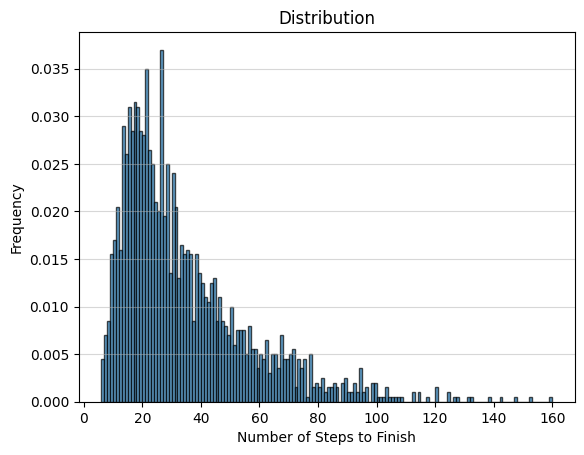

np.float64(33.8315)

In [19]:

from typing import Dict
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

RL_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if RL_ROOT not in sys.path:
    sys.path.append(RL_ROOT)
from rl.markov_process import FiniteMarkovProcess, NonTerminal
from rl.distribution import Categorical


def snakes_and_ladders_process() -> FiniteMarkovProcess[int]:
    snakes_and_ladders: Dict[int, int] = {
        # ladders
        1: 38,
        4: 14,
        8: 30,
        21: 42,
        28: 76,
        50: 67,
        71: 92,
        80: 99,
        # snakes
        32: 10,
        36: 6,
        48: 26,
        62: 18,
        88: 24,
        95: 56,
        97: 78,
    }

    transition_map: Dict[int, Categorical[int]] = {}
    for s in range(100):
        outs: Dict[int, float] = {}
        for roll in range(1, 7):
            next_raw = s + roll
            if next_raw >= 100:
                next_s = 100
            else:
                next_s = snakes_and_ladders.get(next_raw, next_raw)

            outs[next_s] = outs.get(next_s, 0.0) + 1.0 / 6.0
        transition_map[s] = Categorical(outs)

    return FiniteMarkovProcess(transition_map)
process = snakes_and_ladders_process()


graph = process.generate_image()

start_state = Categorical({NonTerminal(0): 1.0})
num_traces = 2000
lengths = []
for i, trace in enumerate(process.traces(start_state)):
    if i >= num_traces:
        break
    trace_list = list(trace)
    lengths.append(len(trace_list) - 1)

plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), density=True, alpha=0.7, edgecolor='black')
plt.title(f"Distribution")
plt.xlabel("Number of Steps to Finish")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.show()
avg_steps = np.mean(lengths)
avg_steps

## Question 2: Markov Decision Processes (Led by Xiao Huang)

Consider an MDP with an infinite set of states ${S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by:
$$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in S \text{ for all } a \in [0,1]$$
For all states $s \in {S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Problem Statement

How can we derive a mathematical formulation for the value function and the optimal policy? And how do those functions change when we modify the action space?

---

### Subquestions

#### Part (A): Optimal Value Function  

Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in {S}$. Given $V^*(s)$, what is the optimal action, $a^*$, that maximizes the optimal value function?

---

#### Part (B): Optimal Policy  

Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in {S}$.

---

#### Part (C): Changing the Action Space  

Let's assume that we modify the action space such that instead of $a \in [0,1]$ for all states, we restrict the action space to $a \in \left[0,\frac{1}{s}\right]$ for state $s$. This means that higher states have more restricted action spaces. How does this constraint affect:

- The form of the Bellman optimality equation?
- The optimal value function, $V^*(s)$?
- The structure of the optimal policy, $\pi^*(s)$?

---


### Part (A) Answer


Given

$S = {1,2,3...}$

start state $s_0$ = 1

transistion probability

$P(s+1|s,a) = a$, reward = $1-a$

$P(s|s,a) = 1-a$, reward = $1+a$

$γ = 0.5$

by definition: $R(a):= E[R_{t+1}\mid S_t=s, A_t=a]= a(1-a) + (1-a)(1+a)= a-a^2 + (1-a^2)=1+a-2a^2$ and $R(a)$ does not depend on $s$



from Bellman optimal value function
$V^*(s)=\max_{a\in[0,1]}(R(a)+\gamma[(1-a)V^*(s)+aV^*(s+1)]).
$

from the instructon, the transition and reward is independent on s, as it only deond onwhether we stay or move. the MDP is therefore isomorphic form state s to state s+1.

this MDP has translation invariance
proof: assume $V^*(s)>V^*(s+1)$, at $s+1$, the action space and transition probability and reward are all the same, which contradicts with $V^*(s)>V^*(s+1)$. therefore,

$V^*(s)=V^*(s+1)=V^*$  for all $s$. From this V^*(s) is independent on s, so $V^*(s) = V^*$





Then the value function can be written as:
$
V^*
=\max_{a\in[0,1]}(R(a)+\gamma[(1-a)V^*+aV^*])
=\max_{a\in[0,1]}(R(a)+\gamma V^*)
$

plug in $γ = 0.5$

it gives $V^*=\frac{1}{1-\gamma}\max_{a\in[0,1]}R(a)
=2\max(1+a-2a^2)$

$(1+a-2a^2)$ peaks when a = $\frac{1}{4}$

so $a^* = 1/4$

and $V^*=\frac{1}{1-\gamma}\cdot\frac98=2\cdot\frac98=\frac94$



</span>




</span>

### Part (B) Answer

As we have proved in A, the optimal action for each state is the same, and the optimal value function is a constant at $\frac94$, and within $[0,1]$ the optimal action can be calulated by fining the argmax of $1+a-2a^2$, $a^* = \frac14$.

add on: from Bellman optimal function , for each state, there exist at least 1 action that can achieve the optimal value (dominant). $\pi^*(s)$ achieves the maximum on the RHS of the Bellman optimal value function, so that $V^{\pi^*}(s) = V^*(s)$. Therefore, the optimal policy is

$\pi^*(s)=a^*=\frac14$, $\forall s\in S$



### Part (C) Answer

#### Bellman Optimality Equation Change:
in the question, the action space is changed to: at state $s$, $a∈[0,1/s]$, therefore to achieve maximum on the RHS, the domain is changed with states (different from previous).


$V^*(s) =\max_{a\in[0,1/s]}(R(a)+\gamma[(1-a)V^*(s)+aV^*(s+1)])$
</span>

#### Optimal Value Function Change:
when s becomes larger, then $a<=1/s$ besomes smaller.


$V^*(s)=\max_{a\in[0,1/s]}(
R(a)+\gamma(1-a)V^*(s)+\gamma a V^*(s+1))$

rearrange it, we have:

$V^*(s)-\gamma(1-a)V^*(s) = R(a)+\gamma aV^*(s+1)$

$\big(1-\gamma+\gamma a\big)V^*(s) =R(a)+\gamma a V^*(s+1)$

substitute $R(a)=1+a−2a^2$

$V^*(s)=max_{a∈[0,1/s]}\frac{(1+a−2a^2)+γaV^*(s+1)}{​1−γ+γa}$ where $γ=0.5$

as in this funciton, RHS is dependent on $1/s$, so that $V^*(s)$ changes with $s$


</span>

#### Optimal Policy Change:

$\pi^{*}(s)∈ argmax_{a∈[0,1/s]}​[(1+a-2a^2)+γ(aV^*(s+1)+(1-a)V^*(s))]$

scenario 1: $s= 1,2,3,4$. From the previous part, we have proved that the optimal point is achieved at 1/4 (by this there is no such constraint)

Scenario 2: when $s>4$, then the optimal policy is: $\pi^{*}(s)∈ argmax_{a∈[0,1/s]}​[(1+a-2a^2)+γ(aV^*(s+1)+(1-a)V^*(s))]$, and $\pi^*(s) = 1/s$

When s is becoming very large, then $\pi^*(s)$ approaches 0
</span>

## Question 3: Frog in a Pond (Led by Xiao Huang)

Consider an array of $n+1$ lilypads on a pond, numbered $0$ to $n$. A frog sits on a lilypad other than the lilypads numbered $0$ or $n$. When on lilypad $i$ ($1 \leq i \leq n-1$), the frog can croak one of two sounds: **A** or **B**.

- If it croaks **A** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to lilypad $i-1$ with probability $\frac{i}{n}$.
  - It is thrown to lilypad $i+1$ with probability $\frac{n-i}{n}$.
  
- If it croaks **B** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to one of the lilypads $0, \ldots, i-1, i+1, \ldots, n$ with uniform probability $\frac{1}{n}$.

A snake, perched on lilypad $0$, will eat the frog if it lands on lilypad $0$. The frog can escape the pond (and hence, escape the snake!) if it lands on lilypad $n$.

### Problem Statement

What should the frog croak when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (i.e., reaching lilypad $n$ before reaching lilypad $0$)?

Although there are multiple ways to solve this problem, we aim to solve it by modeling it as a **Markov Decision Process (MDP)** and identifying the **Optimal Policy**.

---

### Subquestions

#### Part (A): MDP Modeling

Express the frog-escape problem as an MDP using clear mathematical notation by defining the following components:

- **State Space**: Define the possible states of the MDP.
- **Action Space**: Specify the actions available to the frog at each state.
- **Transition Function**: Describe the probabilities of transitioning between states for each action.
- **Reward Function**: Specify the reward associated with the states and transitions.

---

#### Part (B): Python Implementation

There is starter code below to solve this problem programatically. Fill in each of the $6$ `TODO` areas in the code. As a reference for the transition probabilities and rewards, you can make use of the example in slide 16/31 from the following slide deck: https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/Tour-MP.pdf.

Write Python code that:

- Models this MDP.
- Solves the **Optimal Value Function** and the **Optimal Policy**.

Feel free to use/adapt code from the textbook. Note, there are other libraries that are needed to actually run this code, so running it will not do anything. Just fill in the code so that it could run assuming that the other libraries are present.

---

#### Part (C): Visualization and Analysis

What patterns do you observe for the **Optimal Policy** as you vary $n$ from $3$ to $25$? When the frog is on lilypad $13$ (with $25$ total), what action should the frog take? Is this action different than the action the frog should take if it is on lilypad $1$?

---

### Part (A) Answer

#### State Space:  

the state sapce of the frog is the number of the lilypad the frog is on $S =
\{0,1,2,...,n\}$

the terminal space is $T = \{0,n\}$ either escape or be eaten :(, the rest are the non terminal states in the space of states.

</span>

#### Action Space:  

the action space is $A(i) = \{A,B\}$ for all the non-terminal spaces $i∈\{1,2,3,...,n-1\}$

at the terminal state, there is no action, as the frog escapes or been eaten
</span>

#### Transition Function:  

for both actions, when the frog stays in the same state, then $P(i|A,i)= 0$ and $P(i,|B,i) = 0$

Action A:

$P(i-1|A,i) = i/n$, and $P(i+1|A,i) = (n-i)/n$

Action B

$P(j|B, i) = 1/n$ for $∀ j∈\{0,1,2,3,...,n\}$ when $i!=j$

the terminal state is absorbing, and P at absorbing is 1.
</span>

#### Reward Function:  

 for the reward fuction, only when the frog escapes, then the reward gives a 1, otherwise,

$r(i, a ,j) = 0$ for when j!=n

and $r(i,a,j) = 1$ when j = n

</span>

### Part (B) Answer

In [21]:
from typing import Dict, Mapping, Tuple
# from rl.markov_decision_process import FiniteMarkovDecisionProcess





MDPRefined = dict


def get_lily_pads_mdp(n: int) -> MDPRefined:
    data = {
        i: {
            'A': {
                i - 1: i/n, # TODO: fill in with the correct transition probabilities
                i + 1: (n-i)/n, # TODO: fill in with the correct transition probabilities
            },
            'B': {
                j: 1/n for j in range (0,n+1) if j!=i # TODO: fill in with the correct transition probabilities
            }
        } for i in range(1, n)
    }
    data[0] = {'A': {0: 1.0}, 'B': {0: 1.0}} # TODO: this is the initial state, so what would be the correct transition probabilities?
    # but if we are using the code from the course repo, do we still need this? as in FiniteMarkovDecisionProcess, they are not in the mapping keys
    data[n] = {'A': {n: 1.0}, 'B': {n: 1.0}} # TODO: similarly, this is the terminal state, so what would be the correct transition probabilities?

    gamma = 1.0
    return MDPRefined(data, gamma)

Mapping = dict
def direct_bellman(n: int) -> Mapping[int, float]:
    vf = [0.5] * (n + 1)
    vf[0] = 0 #eaten
    vf[n] = 1.0 #escape, maximize P of n before 0
    tol = 1e-8
    epsilon = tol * 1e4
    while epsilon >= tol:
        old_vf = [v for v in vf]
        for i in range(1, n):
            vf[i] =   max ((i/n)*old_vf[i-1]+(1-i/n)*old_vf[i+1], (1/n)*sum(old_vf[j] for j in range(0,n+1)if j!=i)) # TODO: fill in with the Bellman update: fine the max for action a and b
        epsilon = max(abs(old_vf[i] - v) for i, v in enumerate(vf))
    return {v: f for v, f in enumerate(vf)}
'''
if __name__ == "__main__": #run the simulation
    n = [3, 25]
    for i in n:

      vf= direct_bellman(i)
      print(vf)
'''
if __name__ == "__main__":
    patterns = {}
    for n in range(3, 26): #vary from 3 to 25
        vf, pi = direct_bellman(n)
        pattern = ''.join(pi[i] for i in range(1, n)) # show the actions
        patterns[n] = pattern
        print(f"n={n:2d}: {pattern}")

    vf25, pi25 = direct_bellman(25)


ValueError: too many values to unpack (expected 2)

### Part (C) Answer


$π^*(1) = B$ and for ∀ i =2,3,...,n-1, $\pi^* = A$. when $n=25$, the frog shold take action A at 13, and it should take action B at 1. This is plausible to as action B introduces eaten probability 1/n from i>2.
</span>

## Question 4: Manual Value Iteration (Led by ___Jackson___)

Consider a simple MDP with ${S} = \{s_1, s_2, s_3\}, {T} = \{s_3\}, {A} = \{a_1, a_2\}$. The State Transition Probability function  
$${P}: {N} \times {A} \times {S} \rightarrow [0, 1]$$  
is defined as:  
$${P}(s_1, a_1, s_1) = 0.25, {P}(s_1, a_1, s_2) = 0.65, {P}(s_1, a_1, s_3) = 0.1$$  
$${P}(s_1, a_2, s_1) = 0.1, {P}(s_1, a_2, s_2) = 0.4, {P}(s_1, a_2, s_3) = 0.5$$  
$${P}(s_2, a_1, s_1) = 0.3, {P}(s_2, a_1, s_2) = 0.15, {P}(s_2, a_1, s_3) = 0.55$$  
$${P}(s_2, a_2, s_1) = 0.25, {P}(s_2, a_2, s_2) = 0.55, {P}(s_2, a_2, s_3) = 0.2$$  

The Reward Function  
$${R}: {N} \times {A} \rightarrow \mathbb{R}$$  
is defined as:  
$${R}(s_1, a_1) = 8.0, {R}(s_1, a_2) = 10.0$$  
$${R}(s_2, a_1) = 1.0, {R}(s_2, a_2) = -1.0$$  

Assume a discount factor of $\gamma = 1$.

### Problem Statement

Your task is to determine an Optimal Deterministic Policy **by manually working out** (not with code) the first two iterations of the Value Iteration algorithm.

---

### Subquestions

#### Part (A): 2 Iterations

1. Initialize the Value Function for each state to be its $\max$ (over actions) reward, i.e., we initialize the Value Function to be $v_0(s_1) = 10.0, v_0(s_2) = 1.0, v_0(s_3) = 0.0$. Then manually calculate $q_k(\cdot, \cdot)$ and $v_k(\cdot)$ from $v_{k - 1}(\cdot)$ using the Value Iteration update, and then calculate the greedy policy $\pi_k(\cdot)$ from $q_k(\cdot, \cdot)$ for $k = 1$ and $k = 2$ (hence, 2 iterations).

---

#### Part (B): Argument

1. Now argue that $\pi_k(\cdot)$ for $k > 2$ will be the same as $\pi_2(\cdot)$. *Hint*: You can make the argument by examining the structure of how you get $q_k(\cdot, \cdot)$ from $v_{k-1}(\cdot)$. With this argument, there is no need to go beyond the two iterations you performed above, and so you can establish $\pi_2(\cdot)$ as an Optimal Deterministic Policy for this MDP.

---

#### Part (C): Policy Evaluation

1. Using the policy $\pi_2(\cdot)$, compute the exact value function $V^{\pi_2}(s)$ for all $s\in S$.

---

#### Part (D): Sensitivity Analysis

Assume the reward for $R(s_1, a_2)$ is modified to $11.0$ instead of $10.0$.

1. Perform one iteration of Value Iteration starting from the initialized value function $v_0(s)$, where $v_0(s)$ remains the same as in the original problem.
2. Determine whether this change impacts the Optimal Deterministic Policy $\pi(\cdot)$. If it does, explain why.

---

### Part (A) Answer




$$q_k(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s') v_{k-1}(s')$$
For the first step, $$ k = 1, \gamma = 1 $$

For state 1,
if we take action 1
$$q_1(s_1, a_1) = R(s_1, a_1) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 8 + (0.25* v_0(s1) + 0.65 * v_0(s2) + 0.1*v_0(s3))$$
$$ = 8 + (2.5 + 0.65 + 0)$$
$$ = 11.15$$

if we take action 2
$$q_1(s_1, a_2) = R(s_1, a_2) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 10 + (0.1* v_0(s1) + 0.4 * v_0(s2) + 0.5*v_0(s3))$$
$$ = 10 + (1 + 0.4 + 0)$$
$$ = 11.4$$

the greedy choice is action 2, and $$ v_1(s1) =11.4 $$

For state 2,
if we take action 1
$$q_1(s_2, a_1) = R(s_2, a_1) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 1 + (0.3* v_0(s1) + 0.15 * v_0(s2) + 0.55*v_0(s3))$$
$$ = 1 + (3 + 0.15 + 0)$$
$$ = 4.15$$

if we take action 2
$$q_1(s_2, a_2) = R(s_2, a_2) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = -1 + (0.25* v_0(s1) + 0.55 * v_0(s2) + 0.2*v_0(s3))$$
$$ = -1 + (2.5 + 0.55 + 0)$$
$$ = 2.05$$

the greedy choice is action 1, and $$ v_1(s2) =4.15 $$

For k = 2,

State 1, action 1
$$q_2(s_1, a_1) = R(s_1, a_1) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 8 + (0.25* v_1(s1) + 0.65 * v_1(s2) + 0.1*v_1(s3))$$
$$ = 8 + (2.85 + 2.6975 + 0)$$
$$ = 13.5475$$

State 1, action 2
$$q_2(s_1, a_2) = R(s_1, a_2) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 10 + (0.1* v_1(s1) + 0.4 * v_1(s2) + 0.5*v_1(s3))$$
$$ = 10 + (1.14 + 1.66 + 0)$$
$$ = 12.8$$

the greedy choice is action 1


State 2, action 1
$$q_2(s_2, a_1) = R(s_2, a_1) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 1 + (0.3* v_1(s1) + 0.15 * v_1(s2) + 0.55*v_1(s3))$$
$$ = 1 + (3.42 + 0.6225 + 0)$$
$$ = 5.0425$$

if we take action 2
$$q_2(s_2, a_2) = R(s_2, a_2) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = -1 + (0.25* v_1(s1) + 0.55 * v_1(s2) + 0.2*v_1(s3))$$
$$ = -1 + (2.85 + 2.2825 + 0)$$
$$ = 4.1325 $$

the greedy choice is action 1



To summarize,when $$ k = 1, \pi_1(s1) = a2, \pi_1(s2) = a1. v_1(s1) = 11.4, v_1(s2) = 4.15$$


when $$ k = 2, \pi_2(s1) = a1, \pi_1(s2) = a1. v_2(s1) = 13.5475, v_2(s2) = 5.0425$$


### Part (B) Answer:  
For state 1:


The reason $a_1$ takes over  $a_2$ is because a1 has a much larger probability for the agent to keep in the game. The probability of transitioning into $s_1$ or $s_2$ is $90%$ compared to the $50%$ of the $a_2$. If transitioned into $s_3$, it is gonna be a permanent 0. As the value of $v(s1)$ and $v(s2)$ is actually growing in the future iterations, the penalty of ending the game is severe, ensuring that $a_1$ is the optimal choice.

For state 2:

It is true that $a_2$ has a lower chance of ending the game. action $a_1$ in state $s_2$ provides a $45\%$ chance of staying in the game, while it is $80%$ for $a_2$. However $a_2$ has a lower chance of staying in the best state $s_1$, which accompanies with large immediate reward. Furthermore, $R(s_2, a_1) = 1.0$ is strictly better than $R(s_2, a_2) = -1.0$. Since $a_1$ offers both a better immediate reward and better future state transitions, it will remain dominant.

### Part (C) Answer:  
our $\pi_2$ is to take $a_1$ in both $s_1$ and $s_2$, so


For $s_1$:

$$ V(s_1) = 8.0 + 1 * [0.25 V(s1) + 0.65 V(s2) + 0.1 V(s3)]$$

$$ V(s_2) = 1.0 + 1 * [0.3 V(s1) + 0.15 V(s2) + 0.55 V(s3)]$$

Simplify

$$ 0.75V(s_1) - 0.65 V(s_2) = 8.0$$

$$ -0.3V(s_1)  + 0.85V(s_2) = 1.0$$

Multiply the second equation by 0.75/0.3 and add to the first equation


$$ 1.475V(s_2) = 8.0 + 0.75/3$$
$$ -0.375V(s_2) = 8.0 + 0.75/3$$

$$ V(s_1) = 16.8$$
$$ V(s_2) = 7.1$$
$$ V(s_3) = 0$$




### Part (D) Answer

#### Value Iteration:  

For state 1,
if we take action 1
$$q_1(s_1, a_1) = R(s_1, a_1) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 8 + (0.25* v_0(s1) + 0.65 * v_0(s2) + 0.1*v_0(s3))$$
$$ = 8 + (2.5 + 0.65 + 0)$$
$$ = 11.15$$

if we take action 2
$$q_1(s_1, a_2) = R(s_1, a_2) + \sum_{s'} P(s, a, s') v_{k-1}(s') $$
$$ = 11 + (0.1* v_0(s1) + 0.4 * v_0(s2) + 0.5*v_0(s3))$$
$$ = 11 + (1 + 0.4 + 0)$$
$$ = 12.4$$



#### Optimal Deterministic Policy:  


Since 12.4 > 11.15, the $\pi_1(s_1) = a_2$, it is still $a_2$. Since the immediate reward now is even higher for $a_2$, it is more attractive to be acted in $k=1$. Moreover, the flip we've seen in part b during $k=2$ is now less likely to happen due to its increase in the immediate Reward. For $a_1$ to become attractive again, we need the long-term/ future value of $v(s_1)$ grow large enough to overcome the immediate reward increase of $a_2$

## Question 5: Fixed-Point and Policy Evaluation True/False Questions (Led by __Jackson__)

### Recall Section: Key Formulas and Definitions

#### Bellman Optimality Equation
The Bellman Optimality Equation for state-value functions is:
$$
V^*(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^*(s') \right].
$$
For action-value functions:
$$
Q^*(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s') \max_{a'} Q^*(s', a').
$$

#### Contraction Property
The Bellman Policy Operator $B^\pi$ is a contraction under the $L^\infty$-norm:
$$
\|B^\pi(X) - B^\pi(Y)\|_\infty \leq \gamma \|X - Y\|_\infty.
$$
This guarantees convergence to a unique fixed point.

#### Policy Iteration
Policy Iteration alternates between:
1. **Policy Evaluation**: Compute $V^\pi$ for the current policy $\pi$.
2. **Policy Improvement**: Generate a new policy $\pi'$ by setting:
   $$
   \pi'(s) = \arg\max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^\pi(s') \right].
   $$

#### Discounted Return
The discounted return from time step $t$ is:
$$
G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i,
$$
where $\gamma \in [0, 1)$ is the discount factor.

### True/False Questions (Provide Justification)

1. **True/False**: If $Q^\pi(s, a) = 5$, $P(s, a, s') = 0.5$ for $s' \in \{s_1, s_2\}$, and the immediate reward $R(s, a)$ increases by $2$, the updated action-value function $Q^\pi(s, a)$ also increases by $2$.


---

2. **True/False**: For a discount factor $\gamma = 0.9$, the discounted return for rewards $R_1 = 5, R_2 = 3, R_3 = 1$ is greater than $6$.

---

3. **True/False**: The Bellman Policy Operator $B^\pi(V) = R^\pi + \gamma P^\pi \cdot V$ satisfies the contraction property for all $\gamma \in [0, 1)$, ensuring a unique fixed point.

---

4. **True/False**: In Policy Iteration, the Policy Improvement step guarantees that the updated policy $\pi'$ will always perform strictly better than the previous policy $\pi$.

---

5. **True/False**: If $Q^\pi(s, a) = 10$ for all actions $a$ in a state $s$, then the corresponding state-value function $V^\pi(s) = 10$, regardless of the policy $\pi$.

---

6. **True/False**: The discounted return $G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i$ converges to a finite value for any sequence of bounded rewards if $\gamma < 1$.

---

### Answers (Provide justification, brief explanations are fine)

#### Question 1:  

True.

Assuming other variables unchanged, the formula $$
Q^*(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s') \max_{a'} Q^*(s', a').
$$ tells that increase in $R(s,a)$ immediately add the value of $Q$ by 2.

#### Question 2:  
True.


$$G_0 = 5 + 0.9 * 3 + 0.9^2 * 1 = 8.51 > 6$$ So, yes, the discounted return is greater than 6.


#### Question 3:  

True.


$$B^{\pi}(X)(s) - B^{\pi}(Y)(s) = \gamma \sum_{s'}P^{\pi}(s, s')[X(s') - Y(s')] $$

By Triangular Inequality,

$$|\gamma \sum_{s'}P^{\pi}(s, s')[X(s') - Y(s')]|< = \gamma \sum_{s'}P^{\pi}(s, s')|X(s') - Y(s')|$$

Therefore,

$$|B^{\pi}(X)(s) - B^{\pi}(Y)(s)| <= \gamma \sum_{s'}P^{\pi}(s, s')|X(s') - Y(s')| $$

Since $$|X(s') - Y(s')| <= max_{s^{''}}|X(s'') - Y(s'')| = ||X-Y||_{\infty}$$

Then,

$$|B^{\pi}(X)(s) - B^{\pi}(Y)(s)| <= \gamma \sum_{s'}P^{\pi}(s, s')||X - Y||_{\infty} $$

Since $\sum_{s'}P^{\pi}(s, s') = 1$,

$$|B^{\pi}(X)(s) - B^{\pi}(Y)(s)| <= \gamma ||X - Y||_{\infty} $$

This is true for all s, so

$$max_{s}|B^{\pi}(X)(s) - B^{\pi}(Y)(s)| <= \gamma ||X - Y||_{\infty} $$

Thus,

$$ ||B^{\pi}(X) - B^{\pi}(Y)||_{\infty} <= \gamma ||X - Y||_{\infty} $$


#### Question 4:  

False.


Policy Improvement ensures $V^{\pi}(s') >= V^{\pi}(s)$. However, if the policy is already optimal, $\pi_{s'} = \pi_{s}$, there is no strict improvement.

#### Question 5:  

True.

Since $$V^{\pi}(s) = \sum_{a}\pi(a|s) * Q^{\pi}(s, a)$$ having  $$ Q^{\pi}(s, a) = 10$$ fixes the value of Q and
$$V^{\pi}(s) = \sum_{a}\pi(a|s) * 10$$
$$V^{\pi}(s) =  10$$


#### Question 6:  

True.

Assume reward $R$ is bounded by $X$, then by triangular inequality

$$|G_t| <= \sum^{\infty}_{i = t+1}\gamma^{i - t-1} |R_i|$$
$$|G_t| <= \sum^{\infty}_{i = t+1}\gamma^{i - t-1} X$$
$$|G_t| <= X\sum^{\infty}_{i = t+1}\gamma^{i - t-1}$$

Let k = i - t- 1, then it is a geometric series that

$$X\sum^{\infty}_{k=0}\gamma^{k} = \frac{X}{1 - \gamma} < \infty$$

This ensures convergence as long as $\gamma < 1$.